In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import optuna
from optuna.samplers import TPESampler
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score

/home/vigrel/Git/ML-project/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [3]:
FILE = "../data/raw/database0001.csv"


def load_data(file_path="../data/raw/database0001.csv") -> pd.DataFrame:
    return pd.read_csv(file_path)


In [4]:
wine = load_data()


<AxesSubplot: >

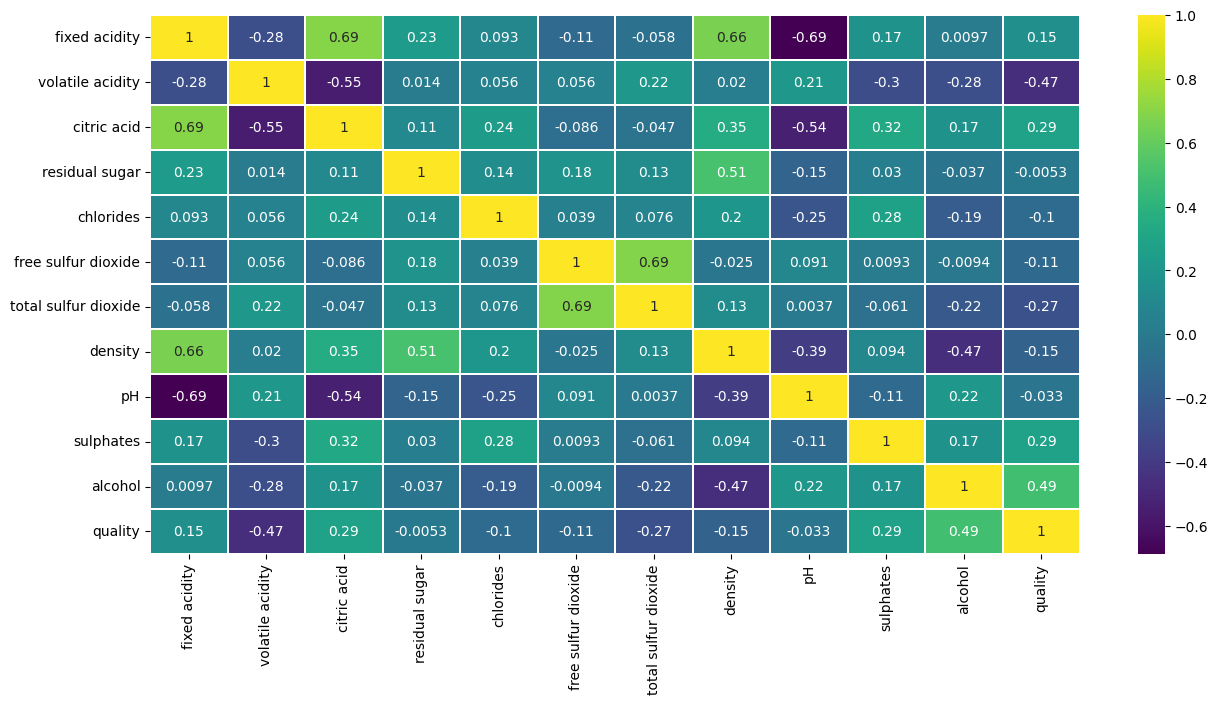

In [5]:
f, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(
    wine.corr(),
    linewidths=0.01,
    annot=True,
    cmap="viridis",
    linecolor="white",
    xticklabels=wine.columns,
    yticklabels=wine.columns,
)


In [6]:
# from sklearn.preprocessing import MinMaxScaler

# transformer = MinMaxScaler()

# for i in wine:
#     wine.loc[:,i] = transformer.fit_transform([wine.loc[:,i]])[0]


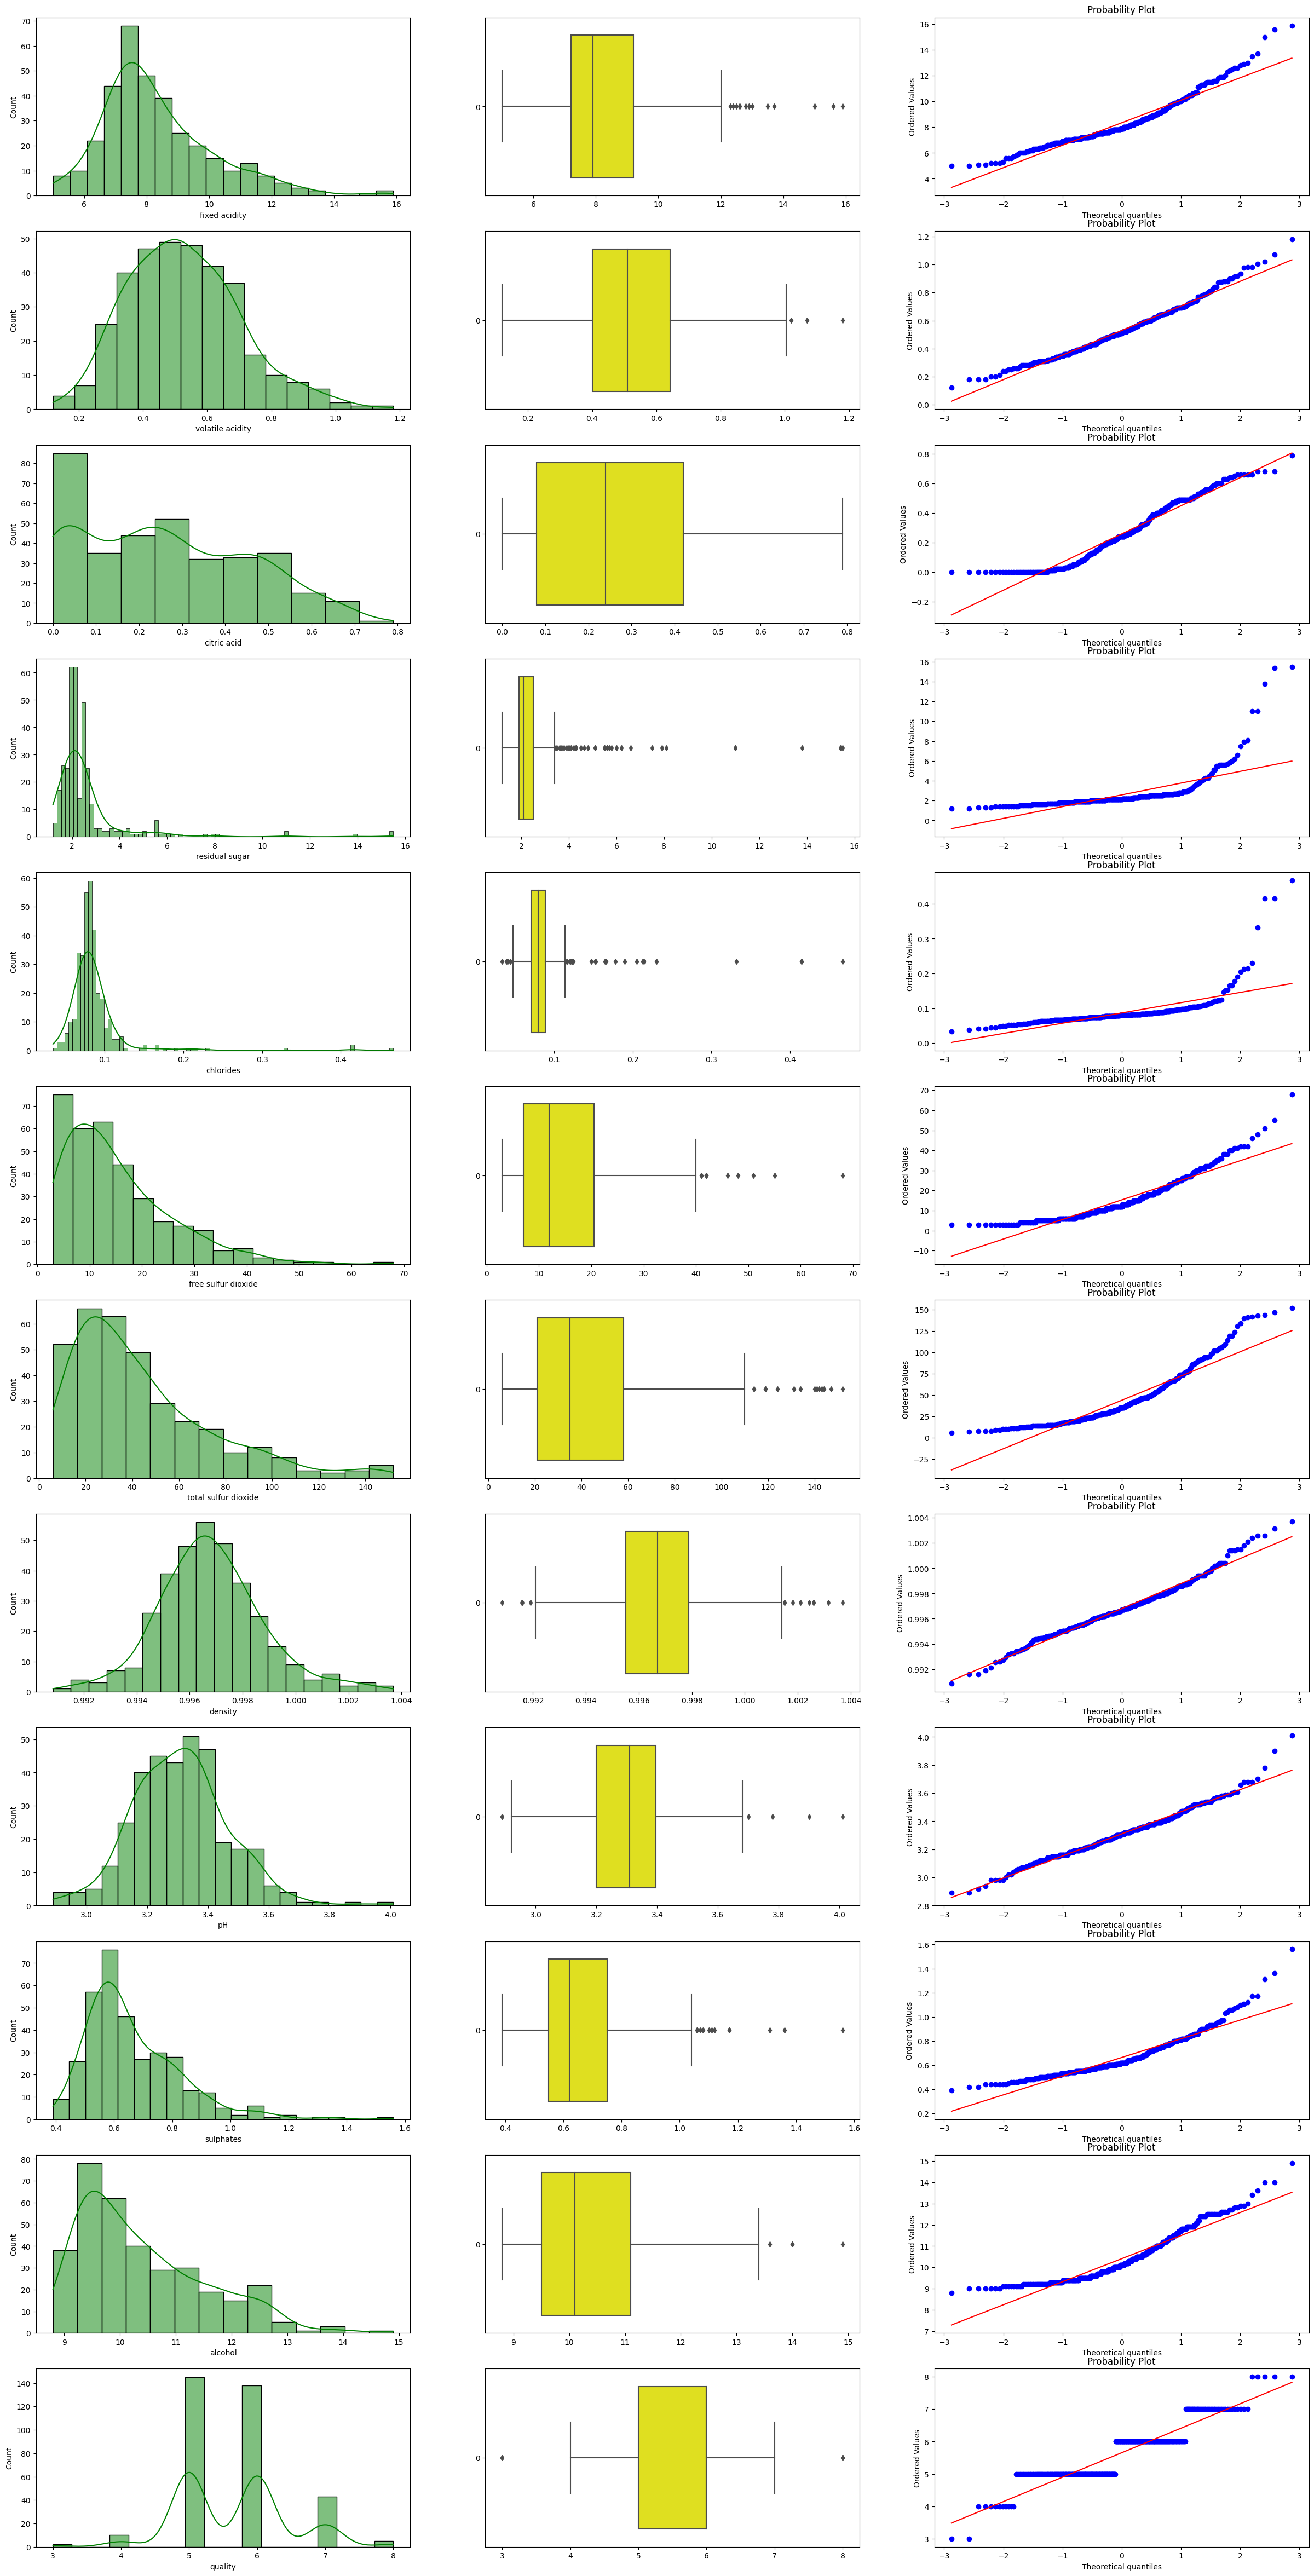

In [7]:
fig,ax = plt.subplots(len(wine.columns),3,figsize=(30,60))
for index,i in enumerate(wine.columns):
    sns.histplot(wine[i],ax=ax[index,0],color='green', kde=True)
    sns.boxplot(wine[i],ax=ax[index,1],color='yellow', orient='h')
    stats.probplot(wine[i],plot=ax[index,2])


# Stratificação

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42,
)
for train_index, test_index in split.split(wine, wine["quality"]):
    train_set = wine.loc[train_index]
    test_set = wine.loc[test_index]


In [9]:
train_set = train_set[train_set.quality != 3]
test_set = test_set[test_set.quality != 3]
train_set = train_set[train_set.quality != 8]
test_set = test_set[test_set.quality != 8]

X_train, Y_train = train_set.drop(columns="quality"), train_set.quality
X_test, Y_test = test_set.drop(columns="quality"), test_set.quality


# Pipeline0001

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

tsd, chl, rs, qual = [
    wine.columns.get_loc(i)
    for i in ["total sulfur dioxide", "chlorides", "residual sugar", "quality"]
]


class LogAtt(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_l = X
        X_l[:, tsd] = np.log(X[:, tsd])
        X_l[:, chl] = np.log(X[:, chl])
        X_l[:, rs] = np.log(X[:, rs])

        return X_l


pipe = LogAtt()


# Testando modelos de forma superficial

In [11]:


Y_train_np = Y_train.to_numpy()
X_train_pp = pipe.transform(X_train.values)
CROSS_VAL = 5


In [12]:
svc_clf = SVC(random_state=RANDOM_SEED)
svc_clf.fit(X_train_pp, Y_train_np)
svc_clf_pred = cross_val_predict(svc_clf, X_train_pp, Y_train_np, cv=CROSS_VAL)

confusion_matrix(Y_train_np, svc_clf_pred), accuracy_score(Y_train_np, svc_clf_pred)


(array([[ 0,  5,  3,  0],
        [ 0, 73, 43,  0],
        [ 0, 49, 61,  0],
        [ 0,  5, 29,  0]]),
 0.5)

In [13]:
sgd_clf = SGDClassifier(random_state=RANDOM_SEED)
sgd_clf.fit(X_train_pp, Y_train_np)
sgd_clf_pred = cross_val_predict(sgd_clf, X_train_pp, Y_train_np, cv=CROSS_VAL)

confusion_matrix(Y_train_np, sgd_clf_pred), accuracy_score(Y_train_np, sgd_clf_pred)


(array([[ 0,  3,  2,  3],
        [ 0, 53, 38, 25],
        [ 0, 23, 50, 37],
        [ 0,  0, 15, 19]]),
 0.4552238805970149)

In [14]:
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
rf_clf.fit(X_train_pp, Y_train_np)
rf_clf_pred = cross_val_predict(rf_clf, X_train_pp, Y_train_np, cv=CROSS_VAL)

confusion_matrix(
    Y_train_np,
    rf_clf_pred,
), accuracy_score(Y_train_np, rf_clf_pred)


(array([[ 0,  4,  4,  0],
        [ 0, 88, 26,  2],
        [ 0, 35, 68,  7],
        [ 0,  1, 21, 12]]),
 0.6268656716417911)

# Tuning hyperparameters

In [15]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "criterion": trial.suggest_categorical("criterion", ['gini', 'entropy']),
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10)
    }

    rf = RandomForestClassifier(**param)

    rf.fit(X_train_pp, Y_train_np)

    preds = rf.predict(X_train_pp)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(Y_train_np, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-09 12:04:28,397] A new study created in memory with name: no-name-107aaa02-bf4b-4ddc-80ea-702f04acd3af
[I 2022-11-09 12:04:29,232] Trial 0 finished with value: 0.7985074626865671 and parameters: {'n_estimators': 798, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7985074626865671.
[I 2022-11-09 12:04:29,889] Trial 1 finished with value: 0.8097014925373134 and parameters: {'n_estimators': 622, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8097014925373134.
[I 2022-11-09 12:04:30,351] Trial 2 finished with value: 0.7798507462686567 and parameters: {'n_estimators': 442, 'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8097014925373134.
[I 2022-11-09 12:04:30,763] Trial 3 finished with value: 0.7798507462686567 and parameters: {'n_estimators': 403, 'criterion': 'entropy',

Number of finished trials: 100
Best trial:
  Value: 0.9813432835820896
  Params: 
    n_estimators: 784
    criterion: entropy
    max_depth: 16
    min_samples_split: 4
    min_samples_leaf: 2


In [21]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
hist = study.trials_dataframe()
hist.tail(5)

Best trial: score 0.9813432835820896,
params {'n_estimators': 784, 'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2}


,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
95,95,0.921642,2022-11-09 12:05:11.866200,2022-11-09 12:05:12.777491,0 days 00:00:00.911291,entropy,13,3,5,832,COMPLETE
96,96,0.981343,2022-11-09 12:05:12.778324,2022-11-09 12:05:13.836950,0 days 00:00:01.058626,entropy,11,2,4,896,COMPLETE
97,97,0.981343,2022-11-09 12:05:13.837977,2022-11-09 12:05:14.700180,0 days 00:00:00.862203,entropy,11,2,4,714,COMPLETE
98,98,0.925373,2022-11-09 12:05:14.700917,2022-11-09 12:05:15.677599,0 days 00:00:00.976682,entropy,10,3,4,886,COMPLETE
99,99,0.981343,2022-11-09 12:05:15.678379,2022-11-09 12:05:16.504487,0 days 00:00:00.826108,entropy,12,2,4,734,COMPLETE
